In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy import signal

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

import random
import warnings

sns.set(style="whitegrid")
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
df= pd.read_csv('data.csv')

Text(0.5, 1.0, 'FTSE CHINA A50 FUT')

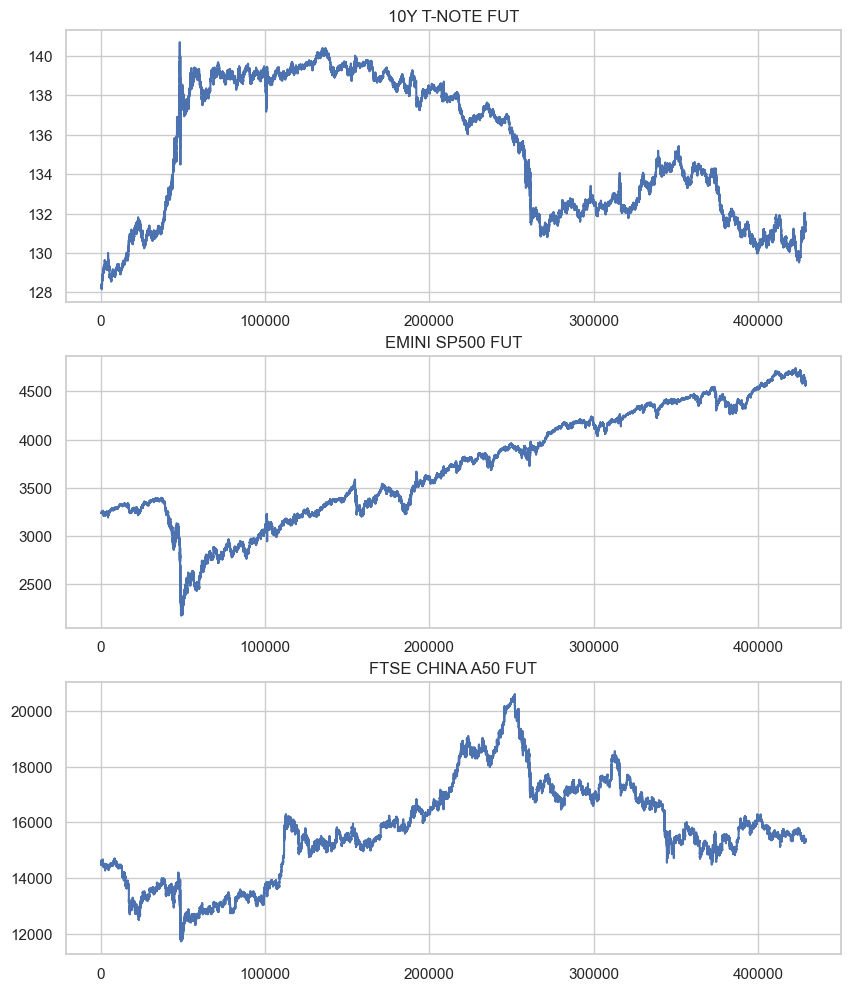

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
axes[0].plot(df.close_ty)
axes[1].plot(df.close_es)
axes[2].plot(df.close_cn)

axes[0].set_title('10Y T-NOTE FUT')
axes[1].set_title('EMINI SP500 FUT')
axes[2].set_title('FTSE CHINA A50 FUT')

## Дизайн исследования

1. Преобразовать котировки в логарифмические приращения. Ожидается, что log returns будут распределны нормально. Рассмотреть полученное распределение приращений.
2. Переход в фазовое пространство: C помощью быстрого преобразования Фурье (FFT) получить представление лог приращений в фазовом пространстве. 
3. Обратный переход из фазового пространства: C помощью обратного FFT вернемся в исходное пространство. Исследовать полученные сдвиги с наибольшими фазовыми амплитудами.
4. Бектест и кросс-валидация

## Proof of Concept

In [5]:
scaler= StandardScaler()
df_close= df[['close_ty', 'close_es', 'close_cn']].copy()
df_zsc= pd.DataFrame(scaler.fit_transform(df_close), 
                     columns= ['close_ty_zsc', 'close_es_zsc', 'close_cn_zsc'])

print(df_zsc.describe())

       close_ty_zsc  close_es_zsc  close_cn_zsc
count  4.291000e+05  4.291000e+05  4.291000e+05
mean   8.482400e-15  3.136920e-16 -1.139253e-17
std    1.000001e+00  1.000001e+00  1.000001e+00
min   -2.032193e+00 -2.607967e+00 -2.235168e+00
25%   -9.242194e-01 -7.569299e-01 -6.701846e-01
50%   -7.306311e-02  3.143629e-03 -5.347136e-02
75%    1.039234e+00  9.356530e-01  6.850096e-01
max    1.584285e+00  1.736399e+00  2.744657e+00


In [6]:
df_zsc['logret_ty'] = np.log(df.close_ty) - np.log(df.close_ty.shift(1))
df_zsc['logret_es'] = np.log(df.close_es) - np.log(df.close_es.shift(1))
df_zsc['logret_cn'] = np.log(df.close_cn) - np.log(df.close_cn.shift(1))

print(df_zsc[['logret_ty', 'logret_es', 'logret_cn']].corr(), '\n')

alpha= .05
s_ty, p_ty= stats.shapiro(df_zsc.logret_ty)
s_es, p_es= stats.shapiro(df_zsc.logret_es)
s_cn, p_cn= stats.shapiro(df_zsc.logret_cn)
df_zsc= df_zsc.dropna()
print(f'Shapiro statisctics: {s_ty}, {s_es}, {s_cn}\n')

# adfuller test for stationarity

print(df_zsc.head(3))

           logret_ty  logret_es  logret_cn
logret_ty   1.000000  -0.256346  -0.158448
logret_es  -0.256346   1.000000   0.474472
logret_cn  -0.158448   0.474472   1.000000 

Shapiro statisctics: nan, nan, nan

   close_ty_zsc  close_es_zsc  close_cn_zsc  logret_ty  logret_es  logret_cn
1      -1.99184     -0.805653     -0.672997        0.0  -0.000077   0.001034
2      -1.99184     -0.805229     -0.671591        0.0   0.000077   0.000172
3      -1.99184     -0.804805     -0.674403        0.0   0.000077  -0.000345


In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
###
sns.lineplot(df_zsc.logret_ty, ax= axes[0,0])
axes[0,0].set_title('10Y T-NOTE FUT log returns')
sns.histplot(df_zsc.logret_ty, kde=False, bins= 10000, ax=axes[0,1])
ax1= axes[0,1].twinx()
sns.ecdfplot(df_zsc.logret_ty, ax= ax1, alpha=0.5, color= 'red', label='empirical CDF')
axes[0,1].set_xlim(-0.0003,0.0003)
axes[0,1].set_title('10Y T-NOTE FUT log returns distribution')

###
sns.lineplot(df_zsc.logret_es, ax= axes[1,0])
axes[1,0].set_title('EMINI SP500 FUT log returns')
sns.histplot(df_zsc.logret_es, kde=False, bins= 10000, ax=axes[1,1])
ax2= axes[1,1].twinx()
sns.ecdfplot(df_zsc.logret_es, ax= ax2, alpha=0.5, color= 'red', label='empirical CDF')
axes[1,1].set_xlim(-0.0008,0.0008)
axes[1,1].set_title('EMINI SP500 FUT log returns distribution')

###
sns.lineplot(df_zsc.logret_ty, ax= axes[2,0])
axes[2,0].set_title('FTSE CHINA A50 FUT log returns')
sns.histplot(df_zsc.logret_ty, kde=False, bins= 10000, ax=axes[2,1])
ax3= axes[2,1].twinx()
sns.ecdfplot(df_zsc.logret_ty, ax= ax3, alpha=0.5, color= 'red', label='empirical CDF')
axes[2,1].set_xlim(-0.0003,0.0003)
axes[2,1].set_title('FTSE CHINA A50 FUT log returns distribution')


In [ ]:
# ADF test
# data = np.array(df_zsc.logret_ty)
# result = adfuller(data)

# adf_statistic = result[0]
# p_value = result[1]
# critical_values = result[4]

# print("ADF Statistic:", adf_statistic)
# print("p-value:", p_value)
# print("Critical Values:")
# for key, value in critical_values.items():
#     print(f"{key}: {value}")
    
# # Interpret the results
# if p_value <= 0.05:
#     print("Reject the null hypothesis: Data is stationary")
# else:
#     print("Fail to reject the null hypothesis: Data is non-stationary")


In [ ]:
def plotter(x,y, x_name, y_name):

    x= np.array(x)
    y= np.array(y)

    fft_x= np.fft.fft(x)
    fft_y= np.fft.fft(y)

    freq_x= np.fft.fftfreq(len(x))
    freq_y= np.fft.fftfreq(len(y))

    magn_x= np.abs(fft_x)
    magn_y= np.abs(fft_y)

    fs = 1000  # Sample rate in Hz
    frequencies, csd = signal.csd(fft_x, fft_y, fs=fs, nperseg=64)

    # Calculate the phase of the CSD
    phase = np.angle(csd) 

    # Complex representation (i.e. combination of phase with magnitude)
    csd_complex = np.abs(csd) * np.exp(1j * phase)

    # Inverse Fourier Transform (IFFT) to return to the time domain
    time_domain_data = np.fft.ifft(csd_complex)

    ###############################################################

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
    plot_grid = plt.GridSpec(3, 2)

    ax= axes[0,0]
    sns.lineplot(fft_x, ax= ax)
    axes[0,0].set_title(f'FFT of log returns {x_name}', weight='bold')
    axes[0,0].set_xlabel('Frequency (Hz)')
    axes[0,0].set_ylabel('Magnitude')
    axes[0,0].grid()

    ax= axes[0,1]
    sns.lineplot(fft_y, ax= ax)
    axes[0,1].set_title(f'FFT of log returns {y_name}', weight='bold')
    axes[0,1].set_xlabel('Frequency (Hz)')
    axes[0,1].set_ylabel('Magnitude')

    ax= axes[1,0]
    sns.lineplot(x=frequencies, y=np.abs(csd), ax= ax)
    axes[1,0].set_yscale("log")
    # axes[1,0].set_xticks(range(-500,500,50))
    axes[1,0].set_xlabel('Frequency (Hz)')
    axes[1,0].set_ylabel('CSD Magnitude')
    axes[1,0].set_title('Cross-Spectral Density (CSD)', weight='bold')

    ax= axes[1,1]
    sns.lineplot(x=frequencies, y=phase, ax= ax)
    # axes[1,1].set_xticks(range(0,500,50))
    axes[1,1].set_xlabel('Frequency (Hz)')
    axes[1,1].set_ylabel('Phase (radians)')
    axes[1,1].set_title('Phase of Cross-Spectral Density (CSD)', weight='bold')

    ax= plt.subplot(plot_grid[2, 0:])
    sns.lineplot(x=range(len(time_domain_data)), y=time_domain_data, ax= ax)
    ax.set_xlabel('Time')
    ax.set_ylabel('Phasor Amplitude')
    ax.set_title(f'CSD Phase in Time Domain, Max_Amp_Lead={np.argmax(time_domain_data)}', weight='bold')

Исследуем полученные результаты преобразования. На графике CSD заметен пик магнитуды в райноне частоты -100Гц. Этой частоте соответствует фаза приблизительно 3.1 радиана. Вернувшись в исходное пространство, обратим внимание на пик фазовой амплитуды и сдвига в 4 минуты. Исследуем полученный сдвиг подробнее.

In [ ]:
plotter(df_zsc.logret_ty, df_zsc.logret_es, '10Y T-NOTE FUT', 'EMINI SP500 FUT')

Создадим простую стратегую:
Если лидер в течении полученного сдвига (4 мин) демонстрирует направленное изменение, то открывается позиция в инструменте-фоллоувере в направлении этого измененения. Еще через 4 минуты позиция ликвидируется.

In [ ]:
def strategy(data, signals=['close_ty', 'close_es'], t_shift=1):
    df= data[signals].copy()
    df['sig1_sh']= df.close_ty.shift(t_shift)
    df['sig2_sh']= df.close_es.shift(t_shift)
    df['sig2_sh_x2']= df.close_es.shift(t_shift * 2)
    df.dropna(inplace= True)
    df['pos'] = 0 
    df.loc[df[signals[0]] < df['sig1_sh'], 'pos'] = 1
    df.loc[df[signals[0]] > df['sig1_sh'], 'pos'] = -1
    df['pnl']= df.pos * (df.sig2_sh_x2 - df.sig2_sh)
    df= df[['close_ty', 'sig1_sh', 'pos', 'close_es', 'sig2_sh', 'sig2_sh_x2', 'pnl']]
    df['cumpnl']= df.pnl.cumsum()
    # print(df.head(20), '\n')
    # print(df.pnl.describe())
    print(f'''
    Total PnL: {df.pnl.sum()}
    Mean PnL per trade: {df.pnl.mean()}
    Win rate: {len(df[df.pnl > 0])/(len(df[df.pnl > 0]) + len(df[df.pnl < 0]))}
    Mean winner: {df[df.pnl > 0].pnl.mean()}
    Mean loser: {df[df.pnl < 0].pnl.mean()}
    Biggest winner: {df.pnl.max()}
    Biggest loser: {df.pnl.min()}
    ''')

    return df.pnl.sum(), df.pnl.cumsum(), df.pnl

_, cumpnl, trades= strategy(data= df, signals=['close_ty', 'close_es'], t_shift=4)

n= np.arange(len(cumpnl))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax= axes[0]
sns.lineplot(x=n, y=cumpnl, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative PnL')
ax.set_title('Equity', weight='bold')

ax= axes[1]
sns.histplot(trades, kde=True, bins= 1000, ax= ax)
ax.set_xlabel('Time')
ax.set_title('PnL per trade Distribution ', weight='bold')
ax.set_xlim(-7,7)
ax.set_ylim(0, 40_000)


## Cross-validation



In [ ]:
class phasorKfoldCV:
     def __init__(self, data, signals, n_folds, l_fold):
          self.data= data
          self.signals= signals
          self.n_folds, self.l_fold = n_folds, l_fold
          self.folds= None
          self.cv_res= None

     def fold_idx(self):
          random_idx= random.sample(range(0, len(self.data) - self.l_fold), self.n_folds)
          folds= [[idx, idx+self.l_fold, idx+self.l_fold + 1, idx+self.l_fold*2] for idx in random_idx]
          self.folds= folds
          return folds

     def phasor_maxamp(self, subdata):
          log_signals= [x.replace('close', 'logret') for x in self.signals]
          x= np.array(subdata[log_signals[0]])
          y= np.array(subdata[log_signals[1]])

          fft_x= np.fft.fft(x)
          fft_y= np.fft.fft(y)

          freq_x= np.fft.fftfreq(len(x))
          freq_y= np.fft.fftfreq(len(y))

          magn_x= np.abs(fft_x)
          magn_y= np.abs(fft_y)

          fs = 1000  # Sample rate in Hz
          frequencies, csd = signal.csd(fft_x, fft_y, fs=fs, nperseg=64)

          # Calculate the phase of the CSD
          phase = np.angle(csd) 

          # Complex representation (i.e. combination of phase with magnitude)
          csd_complex = np.abs(csd) * np.exp(1j * phase)

          # Inverse Fourier Transform (IFFT) to return to the time domain
          time_domain_data = np.fft.ifft(csd_complex)

          return np.argmax(time_domain_data)
     
     def strategy(self, train, test):
          t_shift= self.phasor_maxamp(train)

          df= test[self.signals].copy()
          df['sig1_sh']= df.close_ty.shift(t_shift)
          df['sig2_sh']= df.close_es.shift(t_shift)
          df['sig2_sh_x2']= df.close_es.shift(t_shift * 2)
          df.dropna(inplace= True)
          df['pos'] = 0 
          df.loc[df[self.signals[0]] < df['sig1_sh'], 'pos'] = 1
          df.loc[df[self.signals[0]] > df['sig1_sh'], 'pos'] = -1
          df['pnl']= df.pos * (df.sig2_sh_x2 - df.sig2_sh)
          df= df[['close_ty', 'sig1_sh', 'pos', 'close_es', 'sig2_sh', 'sig2_sh_x2', 'pnl']]
          df['cumpnl']= df.pnl.cumsum()

          return [df.pnl.sum(), df.pnl.mean(), 
                  len(df[df.pnl > 0])/(len(df[df.pnl > 0]) + len(df[df.pnl < 0])+0.000001), 
                  df[df.pnl > 0].pnl.mean(), df[df.pnl < 0].pnl.mean(), df.pnl.max(), df.pnl.min()]

     def strategy_summary(self, idx):
          summary= self.cv_res[idx]
          print(f'''Total PnL: {summary[0]}
          Mean PnL per trade: {summary[1]}
          Win rate: {summary[2]}
          Mean winner: {summary[3]}
          Mean loser: {summary[4]}
          Biggest winner: {summary[5]}
          Biggest loser: {summary[6]}
          ''') 

     def validate(self):
          self.fold_idx()
          summaries= []

          for fold in self.folds:
               train= self.data.iloc[fold[0]:fold[1]].copy()
               test= self.data.iloc[fold[2]:fold[3]].copy()

               train['logret_ty'] = np.log(train.close_ty) - np.log(train.close_ty.shift(1))
               train['logret_es'] = np.log(train.close_es) - np.log(train.close_es.shift(1))
               train['logret_cn'] = np.log(train.close_cn) - np.log(train.close_cn.shift(1))
               train.dropna(inplace= True)

               test['logret_ty'] = np.log(test.close_ty) - np.log(test.close_ty.shift(1))
               test['logret_es'] = np.log(test.close_es) - np.log(test.close_es.shift(1))
               test['logret_cn'] = np.log(test.close_cn) - np.log(test.close_cn.shift(1))
               test.dropna(inplace= True)


               summaries.append(self.strategy(train,test))
          
          return np.array(summaries)

     def summary(self):
          res= self.validate()
          pnls= res.T[0]
          sns.histplot(pnls, bins=40)
          plt.suptitle(f'Distribution of PnL over {self.n_folds} folds')
          plt.title(f'mu= {pnls.mean():.2f}, std={pnls.std():.2f}')

Проведем кросс-валидацию:

In [ ]:
ph= phasorKfoldCV(data= df, signals=['close_ty', 'close_es'], n_folds= 100, l_fold= 44100)
ph.summary()

## Solution

Пики фазовой амплитуды на графике CSD соответствуют наиболее устойчивым lead-lag зависимостям. Значение на оси Time соотвествует сдвигу в минутах.

In [ ]:
plotter(df_zsc.logret_ty, df_zsc.logret_es, '10Y T-NOTE FUT', 'EMINI SP500 FUT')

In [ ]:
plotter(df_zsc.logret_es, df_zsc.logret_cn, 'EMINI SP500 FUT', 'FTSE CHINA A50 FUT')

In [ ]:
plotter(df_zsc.logret_ty, df_zsc.logret_cn, '10Y T-NOTE FUT', 'FTSE CHINA A50 FUT')